In [94]:
import collections
import os.path
from dateutil import parser
import pandas as pd
import numpy as np

import json
import matplotlib.pyplot as plt
import matplotlib.dates as plotdates
import matplotlib.ticker as tkr  
from datetime import datetime, date, timedelta
from os import listdir
from hurry.filesize import size
from os.path import isfile, join, basename
import re


def merge_files(with_hashes, without_hashes):
    
    key_to_hash = collections.defaultdict(lambda : collections.defaultdict(dict))
    
    regex = re.compile("\/[0-9a-z]{2}\/[0-9a-z]{30}",flags=re.MULTILINE)
    regex2 = re.compile("\/tmp\/nxf\.[a-zA-Z0-9]{10}",flags=re.MULTILINE)
    with open(with_hashes, 'r') as file:
        for line in file:
            splits = line.split(' ')
            
            inputfiles = [split[len("input:"):] for split in splits if split.startswith("input:")]
            inputfiles = set([regex.sub('', inputfile) for inputfile in inputfiles])
            inputfiles = set([regex2.sub('', inputfile) for inputfile in inputfiles])
            inputfiles_without_size = set([inputfile.split(':')[0] for inputfile in inputfiles])
            
            key_to_hash[splits[1]][splits[2]][splits[0]] = (inputfiles, inputfiles_without_size)
            
    with open("files_with_hashes.txt", 'w') as output:
        with open(without_hashes, 'r') as file:
            for line in file:
                splits = line.split(' ')
                inputfiles = [split[len("input:"):] for split in splits if split.startswith("input:")]
                inputfiles = set([regex.sub('', inputfile) for inputfile in inputfiles])
                inputfiles = set([regex2.sub('', inputfile) for inputfile in inputfiles])
                
                inputfiles_without_size = set([inputfile.split(':')[0] for inputfile in inputfiles])
                
                hash_id = None
                if len(key_to_hash[splits[1]][splits[2]]) == 1:
                    hash_id = list(key_to_hash[splits[1]][splits[2]].keys())[0]
                else:
                    counter = 0
                    for possible_hash_id, (input_set, _) in key_to_hash[splits[1]][splits[2]].items():
                        if input_set >= inputfiles:
                            hash_id = possible_hash_id
                            counter += 1

                    if hash_id == None:
                        for possible_hash_id, (with_size, input_set) in key_to_hash[splits[1]][splits[2]].items():
                            if input_set >= inputfiles_without_size:
                                hash_id = possible_hash_id
                                print("Match %s %s with %s after ignoring file size" % (splits[1], splits[2], hash_id), inputfiles - with_size)
                                counter += 1
                    
                    if hash_id == None:
                        least_amount_of_mismatches = len(inputfiles_without_size)
                        for possible_hash_id, (_, input_set) in key_to_hash[splits[1]][splits[2]].items():
                            mismatches = len(inputfiles_without_size - input_set)
                            if mismatches < least_amount_of_mismatches:
                                hash_id = possible_hash_id
                                least_amount_of_mismatches = mismatches
                        
                        print("Match %s %s with %s with %d Mismatches" % (splits[1], splits[2], hash_id, least_amount_of_mismatches))
                            
                        
                    if hash_id == None:
                        for possible_hash_id, (_, input_set) in key_to_hash[splits[1]][splits[2]].items():
                            print(possible_hash_id, inputfiles_without_size - input_set)
                        raise Exception("Could not match hash_id for task: %s %s %s" % (splits[0], splits[1],splits[2]) )

                    if counter > 1:
                        print(inputfiles)
                        for possible_hash_id, input_set in key_to_hash[splits[1]][splits[2]].items():
                            print(possible_hash_id)
                        raise Exception("Ambiguity : %s %s" % (splits[1],splits[2]))
                
                output.write("%s %s" % (hash_id, line))
            
            


def load_hashes():
    hashes_by_name_and_id = collections.defaultdict(lambda : collections.defaultdict(dict))
    with open("./nextflow2withhash.log") as file:
        for line in file:
            task_name_and_id, hash_id, _ = line.split('\t')
            task_name_and_id = task_name_and_id.split(' ')
            if len(task_name_and_id) == 2:
                hashes_by_name_and_id[task_name_and_id[0]][task_name_and_id[1]] = hash_id
            elif len(task_name_and_id) == 1:
                hashes_by_name_and_id[task_name_and_id[0]][''] = hash_id
            else:
                raise "Problem"
    return hashes_by_name_and_id

def replace_tmp_with_workdir(input_files_with_hashes):
    workdirs_by_hashes = load_working_dirs_by_hash()
    tmp_pattern = re.compile("/tmp/nxf\.[a-zA-Z0-9]{10}")
    with open("merged_file_with_tmp_removed.txt", "w+") as output:
        with open(input_files_with_hashes, "r") as file:
            for line in file:
                merged_hash, strace_hash, rest = line.split(' ' , 2)
                workdir = workdirs_by_hashes[strace_hash]
                print(rest)
                rest = tmp_pattern.sub(workdir, rest)
                print("%s %s" % (merged_hash, rest))
                output.write("%s %s" % (merged_hash, rest))


def write_input_output_files_with_hash(hashes, input_files, output_files, filename):

    for task_name, v in hashes.items():
        for task_id, hash_for_task in v.items():
            input_files_for_task = ["input:"+path+':'+str(size) for path, size in input_files[task_name][task_id].items()]
            output_files_for_task = ["output:"+path+':'+str(size) for path, size in output_files[task_name][task_id].items()]
            with open(filename, "a") as output:
                output.write("%s %s %s %s %s\n" % (
                hash_for_task, task_name, task_id,
                " ".join(input_files_for_task),
                " ".join(output_files_for_task),
            ))

def write_input_output_file(workdir_log_file, unfiltered_file):
    i = 0
    with open(workdir_log_file) as file:
        for line in file:
            if i % 10 == 0:
                print(i)
            
            i+=1
            hash_id, task_name_and_id, task_working_dir = line.split("\t")
            task_name_and_id = task_name_and_id.split(' ')
            if len(task_name_and_id) == 1:
                task_name = task_name_and_id[0]
                task_id = ''
            elif len(task_name_and_id) == 2:
                task_name = task_name_and_id[0]
                task_id = task_name_and_id[1]
            
            task_working_dir = task_working_dir.strip().replace("/workdir", "../work")
            input_files =  []
            output_files =  []
            with open("%s/.inputs.trace" % task_working_dir, "r") as file:
                for line in file:
                    input_files.append(line.strip())
            
            with open("%s/.outputs.trace" % task_working_dir, "r") as file:
                for line in file:
                    output_files.append(line.strip())
            with open(unfiltered_file, "a") as output:
                output.write("%s %s %s %s %s\n" % (
                hash_id, task_name, task_id,
                " ".join(["input:"+file for file in input_files]),
                " ".join(["output:"+file for file in output_files]),
            ))

def load_working_dirs():
    working_dirs = collections.defaultdict(lambda : collections.defaultdict(dict))
    with open('strace_workdirs.txt', 'r') as file:
        for line in file:
            hash_id, workdir, name = line.strip().split("\t", 3)
            task_working_dir = workdir.strip().replace("/workdir/", "../work/")
            task_name_and_id = name.split(' ')

            if len(task_name_and_id) == 2:
                working_dirs[task_name_and_id[0]][task_name_and_id[1]] = task_working_dir
            elif len(task_name_and_id) == 1:
                working_dirs[task_name_and_id[0]][''] = task_working_dir
            else:
                raise "Problem"
    return working_dirs

def load_working_dirs_by_hash():
    working_dirs = {}
    with open("./nextflow_workdir_by_hash.txt") as file:
        for line in file:
            hash_id, task_working_dir = line.split("\t")
            working_dirs[hash_id] = task_working_dir.strip()
    return working_dirs

    

def load_files():
    input_files_by_task = collections.defaultdict(lambda : collections.defaultdict(dict))
    output_files_by_task = collections.defaultdict(lambda : collections.defaultdict(dict))
    working_dirs = load_working_dirs()
    for task_name, v in working_dirs.items():
        for task_id, working_dir in v.items():
            with open("%s/.inputs.trace" % working_dir, "r") as file:
                for line in file:
                    path, size = line.split(":")
                    input_files_by_task[task_name][task_id][path] = int(size.strip())
            
            with open("%s/.outputs.trace" % working_dir, "r") as file:
                for line in file:
                    path, size = line.split(":")
                    output_files_by_task[task_name][task_id][path] = int(size.strip())

    return input_files_by_task, output_files_by_task


def load_strace_files_from_working_dir(working_dir):
    files_in_dir = listdir(working_dir)
    if(len(files_in_dir) == 0):
        raise Exception("No Strace Files in Working Dir")
        
    strace_files = [file for file in files_in_dir if file.startswith(".strace.")]
    pids = sorted([int(filename.split('.')[2]) for filename in strace_files])
    for pid in pids:
        with open(working_dir + "/.strace." + str(pid), "r") as strace_file:
            yield pid, strace_file.read()
            
def load_strace_files(task_name, task_id):
    
    working_dirs = load_working_dirs()
    print(task_name, task_id, working_dirs[task_name][task_id])
    files_in_dir = listdir(working_dirs[task_name][task_id])
    strace_files = [file for file in files_in_dir if file.startswith(".strace.")]
    pids = sorted([int(filename.split('.')[2]) for filename in strace_files])
    print("Found %d strace files" % len(pids))
    for pid in pids:
        with open(working_dirs[task_name][task_id] + "/.strace." + str(pid), "r") as strace_file:
            yield pid, strace_file.read()

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [86]:
%matplotlib widget
import re


        
    
    
def sys_call_duration_histogram(taskname, task_id):
    sys_call_time_by_syscall = collections.defaultdict(lambda : [])
    print("%s %s" % (taskname, task_id))
    sys_call_times = []
    pid_time_spent_in_syscall = {}
    for pid, strace in load_strace_files(taskname, task_id):
        matches = re.findall("\d{2}:\d{2}:\d{2}.\d{6} ([a-z0-9]{0,8})\(.*\).*<(\d*\.\d*)>", strace)
        
        pid_time_spent_in_syscall[str(pid)] = sum([timedelta(seconds=float(duration)).microseconds for syscall, duration in matches if syscall != "wait4" or syscall != "futex"])
        for syscall, duration in matches:
            if syscall == 'wait4' or syscall == 'futex':
                continue
            sys_call_time_by_syscall[syscall].append(timedelta(seconds=float(duration)).microseconds)
            
        sys_call_times.extend([timedelta(seconds=float(match[1])) for match in matches if syscall != "wait4" or syscall != "futex"])
        
#     fig, ax4 = plt.subplots(1)
   
    
#     read_times_in_micro_seconds = [rt.microseconds for rt in sys_call_times]    
#     logbins = np.logspace(0, np.log10(max(read_times_in_micro_seconds)), 6)
#     print(logbins)
#     ax4.hist(read_times_in_micro_seconds, bins=logbins)
#     ax4.set_xscale('log')
    
#     plt.show()
    
    
    fig, ax1 = plt.subplots()
    
    syscalls, avg_times = zip(*[(syscall, sum(durations)/len(durations)) for syscall, durations in sys_call_time_by_syscall.items() if sum(durations) > 1000 ])
    total_times = [sum(durations) for durations in sys_call_time_by_syscall.values() if sum(durations) > 1000]
    max_times = [max(durations) for durations in sys_call_time_by_syscall.values() if sum(durations) > 1000]


    ax1.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: str(timedelta(microseconds= x))))
    ax1.bar(syscalls, total_times)
    ax1.legend(['Total Time'])

    plt.xticks(rotation=90)
    plt.show()
    fig, ax2 = plt.subplots()

    ax2.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: str(timedelta(microseconds= x))))
    ax2.bar(syscalls, max_times)
    ax2.bar(syscalls, avg_times)
    ax2.legend(['Max Time', 'Average Time'])
    
    plt.xticks(rotation=90)
    plt.show()
    
    
    
    fig, ax7 = plt.subplots(1)
    ax7.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: str(timedelta(microseconds= x))))
    xs, ys = zip(*[(syscall, sum(durations)) for syscall, durations in sys_call_time_by_syscall.items()])
    plt.xticks(rotation=90)
    ax7.bar(xs, ys)
    plt.show()
    
    fig, ax6 = plt.subplots(1)
    
    xs, ys = zip(*[(pid, duration) for pid, duration in pid_time_spent_in_syscall.items() if duration > 10000])
    ax6.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: str(timedelta(microseconds= x))))
    plt.xticks(rotation=90)
    ax6.bar(xs, ys)
    plt.show()
    
        
        

def show_read_graph_for_task_by_id(taskname, task_id):
    print("%s %s" % (taskname, task_id))
    input_files_for_task = input_files[taskname][task_id]
    output_files_for_task = output_files[taskname][task_id]

    base_paths = [basename(filename) for filename in input_files_for_task.keys()]
    min_date = pd.to_datetime("23:59:59")
    max_date = pd.to_datetime("00:00:00")
    bytes_read_per_pid = {}
    file_reads = collections.defaultdict(lambda : set())
    pid_start_duration = {}
    read_times = []
    n_matches = 0
    distinct_reads = set()
    for pid, strace in load_strace_files(taskname, task_id):
        matches = re.findall("(\d{2}:\d{2}:\d{2}.\d{6}) read\(\d<(.*)>,.* (\d*)\) = (\d*) <(\d*\.\d*)>", strace)
        matches = list(filter(lambda t: any(k for k in base_paths if k in t[1]), matches))
        if len(matches) > 0:
            min_date_current_file = min([pd.to_datetime(match[0]) for match in matches])
            min_date = min(min_date, min_date_current_file)
            
            max_date_current_file = max([pd.to_datetime(match[0]) for match in matches])
            max_date = max(max_date, max_date_current_file)
            
            read_times.extend([timedelta(seconds = float(match[4])) for match in matches])
            n_matches += len(matches)
            bytes_read_per_pid[pid] = sum(int(i) for _,_,_,i,_ in matches)
            
            file_access_from_matches_unique = set([(match[0], match[1]) for match in matches])

            for timestamp, strace_filename in file_access_from_matches_unique:
                filename = next((k for k in base_paths if k in strace_filename), False)
                distinct_reads.add(filename)
                pid_start_duration[pid] = (min_date_current_file, max_date_current_file-min_date_current_file)
                file_reads[filename].add((timestamp, pid))

    
    print("Runtime: %s" % (max_date-min_date))
    print("Number Of input Files: %d" % len(base_paths))
    print("Total Bytes Read: %s" % size(sum(s for _,s in bytes_read_per_pid.items())))
    print("Total Time spent Reading: %s" % str(sum(read_times, timedelta())))
    print("Number of Input files: %d (%s)" % (len(input_files_for_task), size(sum([size for size in input_files_for_task.values()]))))
    print("Number of Reads: %s (%d distinct files)" % (str(n_matches), len(distinct_reads)))
    print(','.join(list(distinct_reads)))
    
    
    cmap = get_cmap(len(file_reads))
    i = 0
    legend_labels = []

    fig, ax = plt.subplots(1)
    
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(plotdates.DateFormatter("%H:%M:%S"))
    
    for filename, points in file_reads.items():
        xs, ys = zip(*points)
        zero = datetime(2018,1,1)
        time = [zero + (pd.to_datetime(t) - min_date) for t in xs]
        # convert datetimes to numbers
        zero = plotdates.date2num(zero)
        time = [t-zero for t in plotdates.date2num(time)]
        ax.scatter(time, [y for y in ys], s=1, alpha=0.8, color=cmap(i))
        plt.suptitle("Reading Access to Input Files")
        ax.set_ylabel('PIDs')
        ax.set_xlabel('Timestamp HH:MM:SS')
        xfmt = md.DateFormatter('%H:%M:%S')
        ax.xaxis.set_major_formatter(xfmt)
        plt.xticks(rotation=90)
        i += 1
        
    plt.show()
    
    fig, ax2 = plt.subplots(1)
    ax2.xaxis_date()
    ax2.xaxis.set_major_formatter(plotdates.DateFormatter("%H:%M:%S"))
 
    
    i = 0
    cmap = get_cmap(len(pid_start_duration))
    for pid, (start, duration) in pid_start_duration.items():
        if duration < timedelta(seconds=1):
            continue
        zero = datetime(2018,1,1)
        start = (start - min_date) + zero
        duration = zero + duration
        # convert datetimes to numbers
        zero = plotdates.date2num(zero)
        start = plotdates.date2num(start) - zero
        duration = plotdates.date2num(duration) - zero

        ax2.barh(str(pid), duration, left=start, color=cmap(i))
        plt.xticks(rotation=90)
        i += 1
    
    plt.show()  
     
        
    fig, ax3 = plt.subplots(1)
    
    ax3.yaxis.set_major_formatter(tkr.FuncFormatter(lambda x, pos: size(x)))
    relevant_pids = [(str(pid), bytes_read) for pid, bytes_read in bytes_read_per_pid.items() if bytes_read > 100]
    xs, ys = zip(*relevant_pids)
    ax3.bar(xs, ys)
    plt.xticks(rotation=90)
    
    plt.show()
    
    fig, ax4 = plt.subplots(1)
   
    
    read_times_in_micro_seconds = [rt.microseconds for rt in read_times]    
    logbins = np.logspace(0, np.log10(max(read_times_in_micro_seconds)), 6)
    print(logbins)
    ax4.hist(read_times_in_micro_seconds, bins=logbins)
    ax4.set_xscale('log')
    ax4.get_xaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: str(x)))
    
    
    plt.show()
    
    
def show_read_graph_for_task(taskname, idx=None):
    working_dirs = load_working_dirs()
    if idx == None: 
        for task_id in working_dirs[taskname].keys():
            show_read_graph_for_task_by_id(taskname, task_id)
    else:
        show_read_graph_for_task_by_id(taskname, list(working_dirs[taskname].keys())[idx])
        
    
def sys_call_duration_histogram_for_task(taskname, idx=None):
    working_dirs = load_working_dirs()
    if idx == None: 
        for task_id in working_dirs[taskname].keys():
            sys_call_duration_histogram(taskname, task_id)
    else:
        sys_call_duration_histogram(taskname, list(working_dirs[taskname].keys())[idx])


In [87]:
input_files, output_files = load_files()

In [91]:
def gantt_chart_by_pid(taskname, idx):
    if isinstance(idx, int): 
        working_dirs = load_working_dirs()
        idx = list(working_dirs[taskname].keys())[idx]
    
    pids = []
    
    regex = re.compile("(\d{2}:\d{2}:\d{2}.\d{6})") 
    for pid, strace in load_strace_files(taskname, idx):
        print(pid)
        splits = strace.split('\n')
        start, end = splits[0], splits[-2]
        start, end = regex.match(start)[0], regex.match(end)[0]
        
        diff = pd.to_datetime(end) - pd.to_datetime(start)
        pids.append((pid, pd.to_datetime(start), diff))
        
    return pids

def first_read_historgram(taskname, idx):
    if isinstance(idx, int): 
        working_dirs = load_working_dirs()
        idx = list(working_dirs[taskname].keys())[idx]
    
    

    read_regex = re.compile("(\d{2}:\d{2}:\d{2}.\d{6}) read\(\d<(.*)>,.* (\d*)\) = (\d*) <(\d*\.\d*)>") 
    accessed_files = set()
    read_times = []    
    
    input_files_for_task = input_files[taskname][idx]
    output_files_for_task = output_files[taskname][idx]
    base_paths = [basename(filename) for filename in input_files_for_task.keys()]
    
    for pid, strace in load_strace_files(taskname, idx):
        matches = read_regex.findall(strace)
        matches = list(filter(lambda t: any(k for k in base_paths if k in t[1]), matches))
        for match in matches:
            if match[1] in accessed_files:
                continue
            accessed_files.add(match[1])
            read_times.append(float(match[4]))
    
    return read_times
    
    
def all_reads_histogram(taskname, idx):
    if isinstance(idx, int): 
        working_dirs = load_working_dirs()
        idx = list(working_dirs[taskname].keys())[idx]
    
    read_regex = re.compile("(\d{2}:\d{2}:\d{2}.\d{6}) read\(\d<(.*)>,.* (\d*)\) = (\d*) <(\d*\.\d*)>") 
    read_times = []    
    
    input_files_for_task = input_files[taskname][idx]
    output_files_for_task = output_files[taskname][idx]
    base_paths = [basename(filename) for filename in input_files_for_task.keys()]
    
    for pid, strace in load_strace_files(taskname, idx):
        matches = read_regex.findall(strace)
        matches = list(filter(lambda t: any(k for k in base_paths if k in t[1]), matches))
        for match in matches:
            read_times.append(float(match[4]))
    
    return read_times
    

In [92]:
today = datetime.today() # or datetime.now to use local timezone 
daystart = datetime(year=today.year, month=today.month, 
                    day=today.day, hour=0, second=0)

preprocessing:mergeBOA (X0111_Y0101) ../work/work/c0/55591f4167061ea094f1343855cba6
Found 0 strace files


IndexError: list index out of range

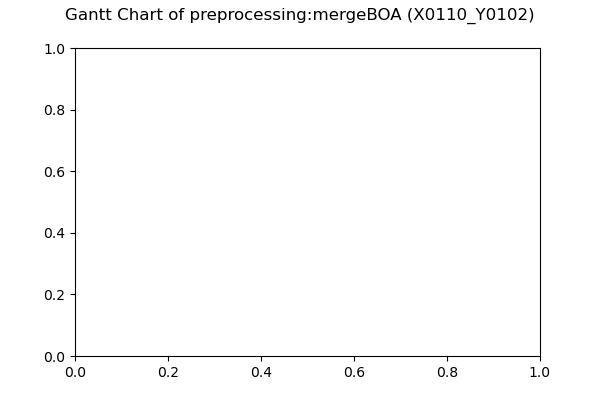

In [93]:
import matplotlib.dates as md


data = gantt_chart_by_pid("preprocessing:mergeBOA", 0)

data = [pid for pid in data if pid[2] > timedelta(seconds=5)]

# Filter out processes than run for less than 1 second
data = [pid for pid in data if pid[2] > timedelta(seconds=5)]


fig,ax=plt.subplots(figsize=(6,4))
plt.suptitle("Gantt Chart of preprocessing:mergeBOA (X0110_Y0102)")
pids = [int(task[0]) for task in data]
# Normalize start time
start = data[0][1]
start_times = [daystart + (task[1] - start) for task in data]
durations = [task[2] for task in data]
ypos = range(len(data))

ax.barh(pids, durations, left=start_times, height=0.7, align='center', color='blue',edgecolor='black')
# ax.set_yticks(ypos, pids)
# ax.axis('tight')
ax.set_ylabel('PIDs')
ax.set_xlabel('Timestamp HH:MM:SS')
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

plt.show()


preprocessing:mergeBOA (X0110_Y0102) ../work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files
preprocessing:mergeBOA (X0110_Y0102) ../work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files


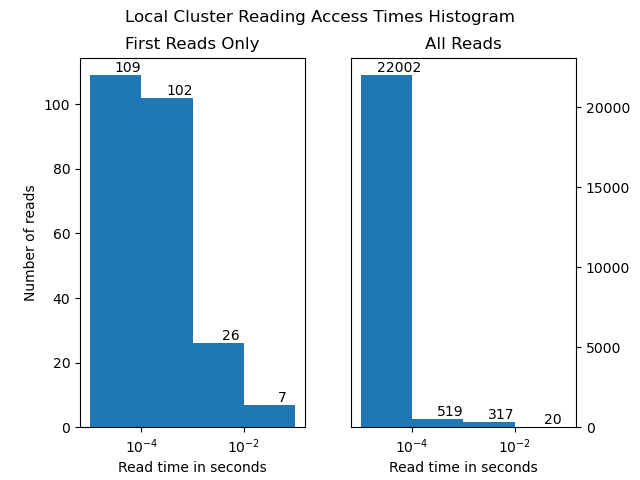

In [78]:
import matplotlib.ticker as mticker  

logbins = np.logspace(-5, -1, 5)

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle("Local Cluster Reading Access Times Histogram")
ax1.set_title('First Reads Only')
_, _, bars = ax1.hist(first_read_historgram("preprocessing:mergeBOA", 0), bins=logbins)
ax1.set_xscale('log')
ax1.bar_label(bars)
ax1.set_ylabel('Number of reads')
ax1.set_xlabel('Read time in seconds')


ax2.set_title('All Reads')
_, _, bars = ax2.hist(all_reads_histogram("preprocessing:mergeBOA", 0), bins=logbins)
ax2.yaxis.tick_right()
ax2.set_xscale('log')
ax2.bar_label(bars)
ax2.set_xlabel('Read time in seconds')

plt.show()



preprocessing:mergeBOA (X0110_Y0102)
preprocessing:mergeBOA (X0110_Y0102) ../work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files
Runtime: 0 days 00:08:59.382561
Number Of input Files: 136
Total Bytes Read: 1G
Total Time spent Reading: 0:00:02.110730
Number of Input files: 136 (818M)
Number of Reads: 36861 (68 distinct files)
20130611_LEVEL2_LND07_BOA.tif,20140918_LEVEL2_LND07_BOA.tif,20141105_LEVEL2_LND07_BOA.tif,20150414_LEVEL2_LND07_BOA.tif,20150905_LEVEL2_LND07_BOA.tif,20150124_LEVEL2_LND07_BOA.tif,20140801_LEVEL2_LND07_BOA.tif,20140716_LEVEL2_LND07_BOA.tif,20160705_LEVEL2_LND07_BOA.tif,merge-boa.r,20130814_LEVEL2_LND07_BOA.tif,20140105_LEVEL2_LND07_BOA.tif,20141207_LEVEL2_LND07_BOA.tif,20131118_LEVEL2_LND07_BOA.tif,20150617_LEVEL2_LND07_BOA.tif,20150719_LEVEL2_LND07_BOA.tif,20151226_LEVEL2_LND07_BOA.tif,20130830_LEVEL2_LND07_BOA.tif,20161025_LEVEL2_LND07_BOA.tif,20130510_LEVEL2_LND07_BOA.tif,20130203_LEVEL2_LND07_BOA.tif,20140529_LEVEL2_LND07_BOA.tif,20160518_LEVEL2

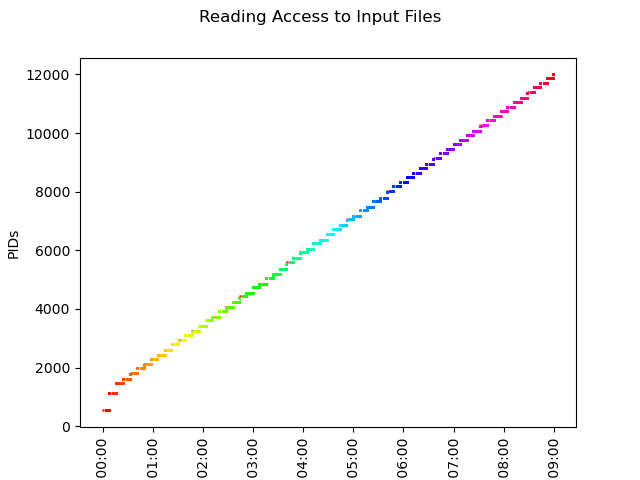

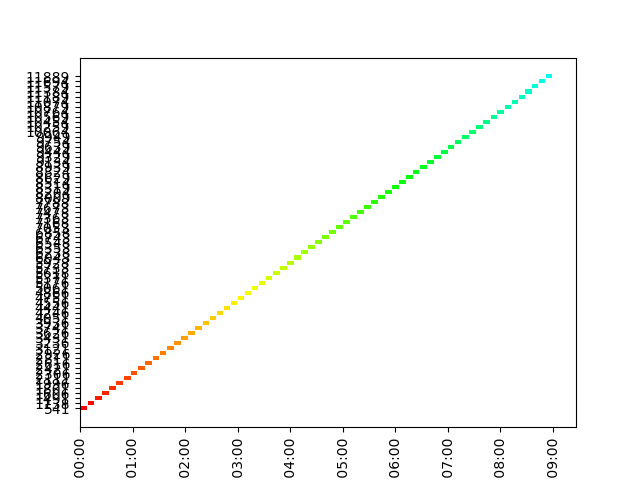

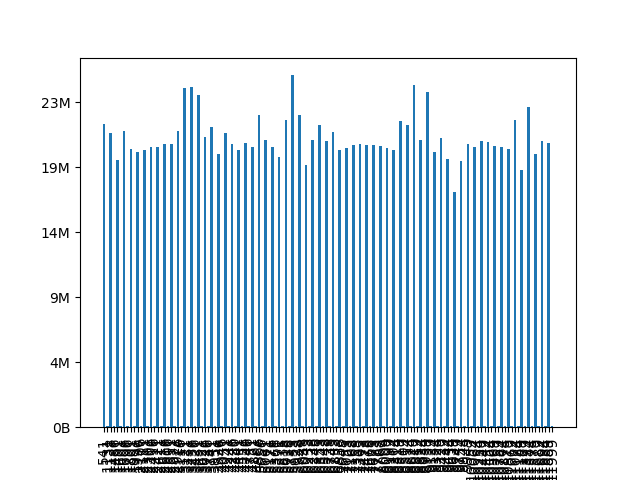

[1.00000000e+00 9.80363837e+00 9.61113252e+01 9.42240675e+02
 9.23738684e+03 9.05600000e+04]


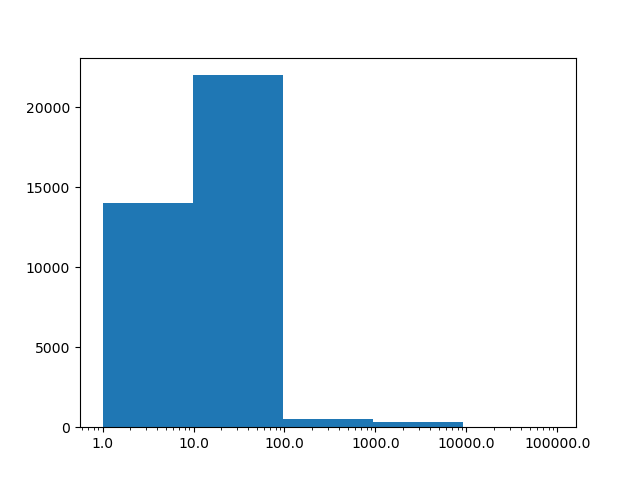

In [77]:
show_read_graph_for_task('preprocessing:mergeBOA', 0)

preprocessing:mergeBOA (X0110_Y0102) ../work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files
[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]


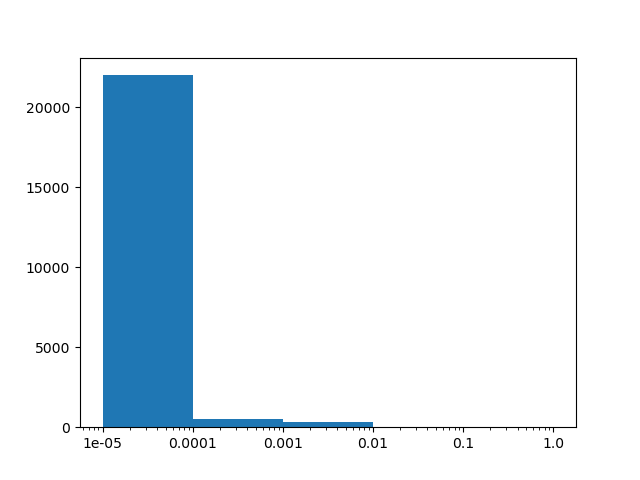

In [88]:
all_reads_histogram("preprocessing:mergeBOA", 0)

preprocessing:mergeBOA (X0110_Y0102)
preprocessing:mergeBOA (X0110_Y0102) ../work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files


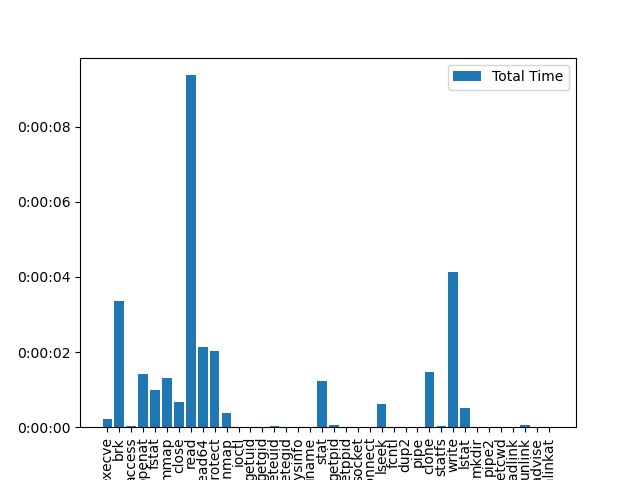

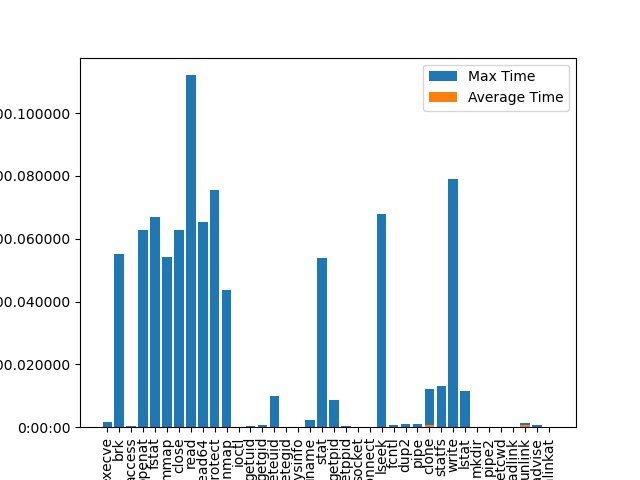

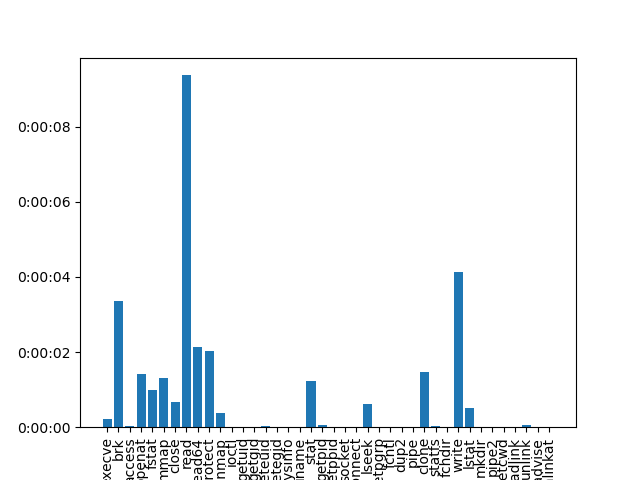

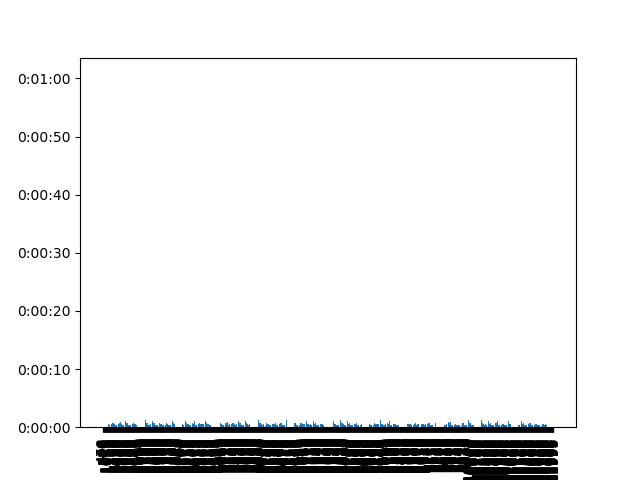

In [54]:
sys_call_duration_histogram_for_task("preprocessing:mergeBOA", 0)

In [52]:
show_read_graph_for_task("preprocessing:mergeBOA", 0)

preprocessing:mergeBOA (X0110_Y0102)


NameError: name 'input_files' is not defined

preprocessing:preprocess (LE07_L1TP_180036_20130316_20161125_01_T1)
preprocessing:preprocess (LE07_L1TP_180036_20130316_20161125_01_T1) ../work/work/37/41d26e0d9dabad6f9f7d06c1b74bc9
Found 168 strace files


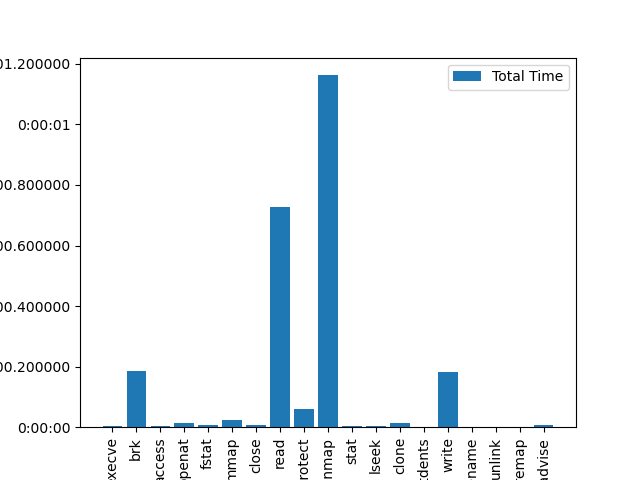

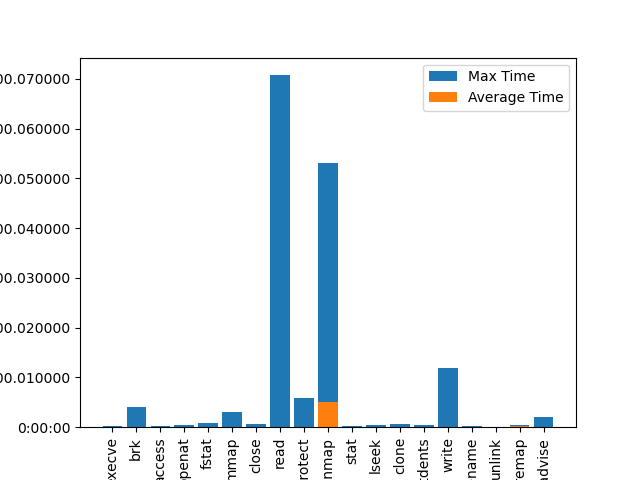

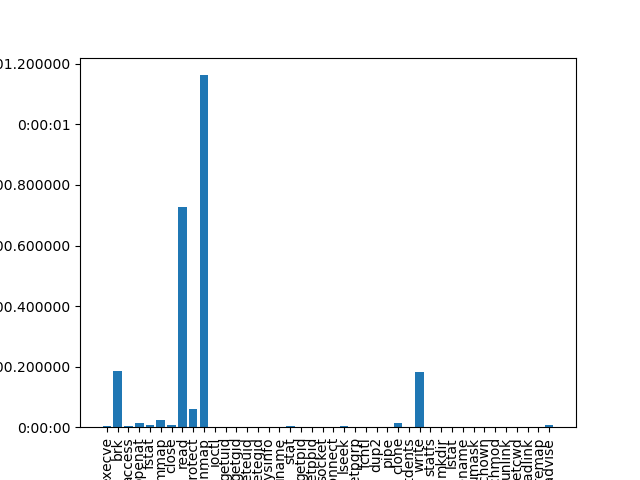

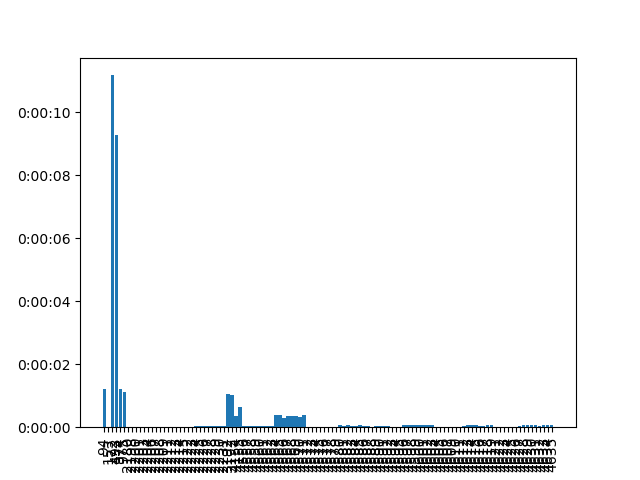

In [36]:
sys_call_duration_histogram_for_task("preprocessing:preprocess", 0)

In [8]:
line = """17:34:19 read(0<pipe:[63364997]>, "./merge.r\n", 4096) = 10"""


re.findall("(\d{2}:\d{2}:\d{2}) read\(\d<(.*)>,.* (\d*)\) = (\d*)", line)


KeyboardInterrupt: 

In [ ]:
def print_json_for_task(task_name, task_id):
    inputs, outputs = load_files()
    
    input_files = []
    output_files = []
    
    for path,size  in inputs[task_name][task_id].items():
        input_files.append({"path": path, "size": size})
    
    for path,size  in outputs[task_name][task_id].items():
        output_files.append({"path": path, "size": size})
    
    json_object = json.dumps({"inputFiles": input_files}, indent = 4) 
    print(json_object)
    json_object = json.dumps({"outputFiles": output_files}, indent = 4) 
    print(json_object)


preprocessing:mergeBOA (X0110_Y0102)
preprocessing:mergeBOA (X0110_Y0102) /home/jovyan/work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files
Runtime: 0 days 00:08:59.382561
Number Of input Files: 136
Total Bytes Read: 1G
Total Time spent Reading: 0:00:02.110730
Number of Input files: 136 (818M)
Number of Reads: 36861 (68 distinct files)
20130510_LEVEL2_LND07_BOA.tif,20140529_LEVEL2_LND07_BOA.tif,20130118_LEVEL2_LND07_BOA.tif,20130203_LEVEL2_LND07_BOA.tif,20141004_LEVEL2_LND07_BOA.tif,20141020_LEVEL2_LND07_BOA.tif,20151226_LEVEL2_LND07_BOA.tif,20161212_LEVEL2_LND07_BOA.tif,20141223_LEVEL2_LND07_BOA.tif,20130915_LEVEL2_LND07_BOA.tif,20150719_LEVEL2_LND07_BOA.tif,20160228_LEVEL2_LND07_BOA.tif,20160822_LEVEL2_LND07_BOA.tif,20140817_LEVEL2_LND07_BOA.tif,20140801_LEVEL2_LND07_BOA.tif,20150225_LEVEL2_LND07_BOA.tif,20160416_LEVEL2_LND07_BOA.tif,20151007_LEVEL2_LND07_BOA.tif,20160721_LEVEL2_LND07_BOA.tif,20140630_LEVEL2_LND07_BOA.tif,merge-boa.r,20160111_LEVEL2_LND07_BOA.tif,20140

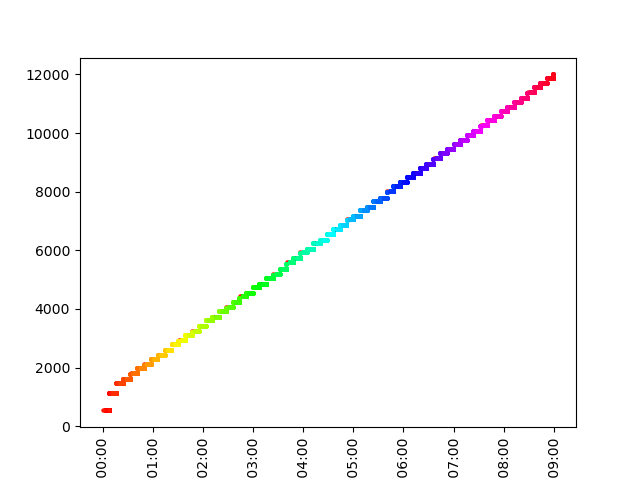

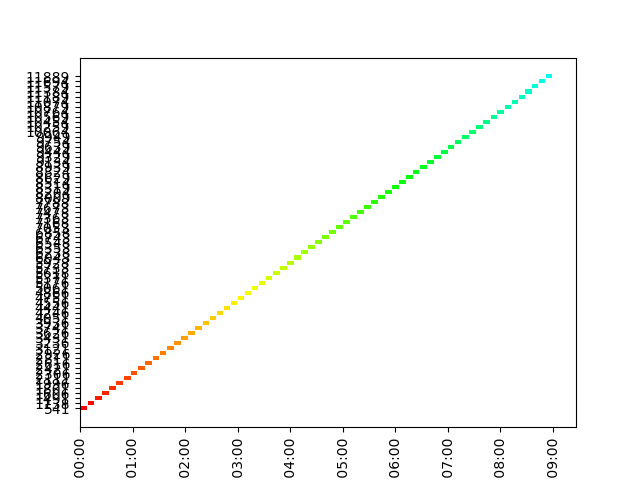

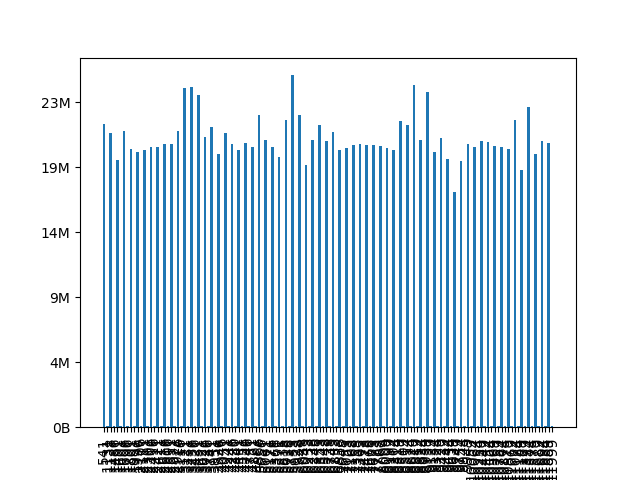

[1.00000000e+00 9.80363837e+00 9.61113252e+01 9.42240675e+02
 9.23738684e+03 9.05600000e+04]


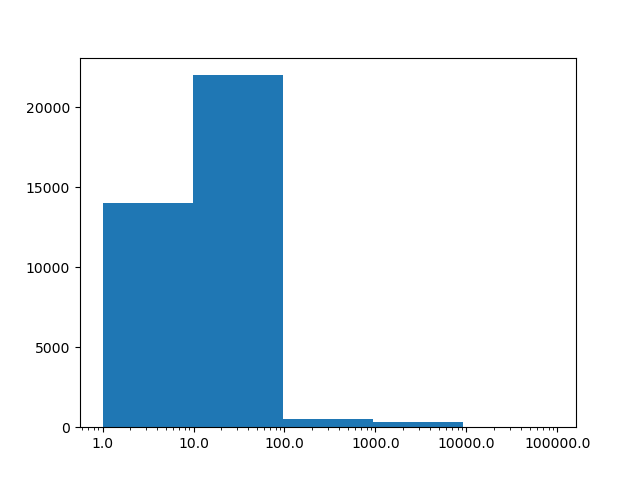

In [11]:
merge_files("unfiltered.txt", "files_without_strace.txt")

Filtering Inputs/Outputs of 507 Tasks based on strace reports
0%
1%
3%


KeyboardInterrupt: 

In [11]:
write_input_output_file("workdirs_perf.txt", "unfiltered.txt")

Filtering Inputs/Outputs of 507 Tasks based on strace reports
0%
1%
3%


KeyboardInterrupt: 

preprocessing:mergeBOA (X0110_Y0102)
preprocessing:mergeBOA (X0110_Y0102) /home/jovyan/work/work/ee/a4a34713849a80d235f33e71752a19
Found 2350 strace files
Runtime: 0 days 00:08:59.382561
Number Of input Files: 136
Total Bytes Read: 1G
Total Time spent Reading: 0:00:02.110730
Number of Input files: 136 (818M)
Number of Reads: 36861 (68 distinct files)
20130510_LEVEL2_LND07_BOA.tif,20140529_LEVEL2_LND07_BOA.tif,20130118_LEVEL2_LND07_BOA.tif,20130203_LEVEL2_LND07_BOA.tif,20141004_LEVEL2_LND07_BOA.tif,20141020_LEVEL2_LND07_BOA.tif,20151226_LEVEL2_LND07_BOA.tif,20161212_LEVEL2_LND07_BOA.tif,20141223_LEVEL2_LND07_BOA.tif,20130915_LEVEL2_LND07_BOA.tif,20150719_LEVEL2_LND07_BOA.tif,20160228_LEVEL2_LND07_BOA.tif,20160822_LEVEL2_LND07_BOA.tif,20140817_LEVEL2_LND07_BOA.tif,20140801_LEVEL2_LND07_BOA.tif,20150225_LEVEL2_LND07_BOA.tif,20160416_LEVEL2_LND07_BOA.tif,20151007_LEVEL2_LND07_BOA.tif,20160721_LEVEL2_LND07_BOA.tif,20140630_LEVEL2_LND07_BOA.tif,merge-boa.r,20160111_LEVEL2_LND07_BOA.tif,20140

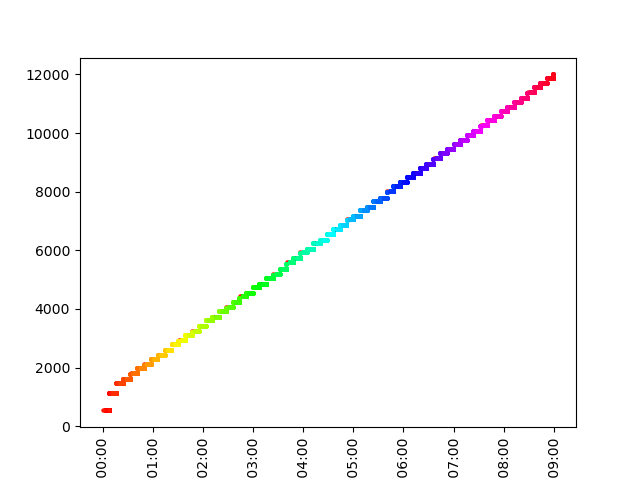

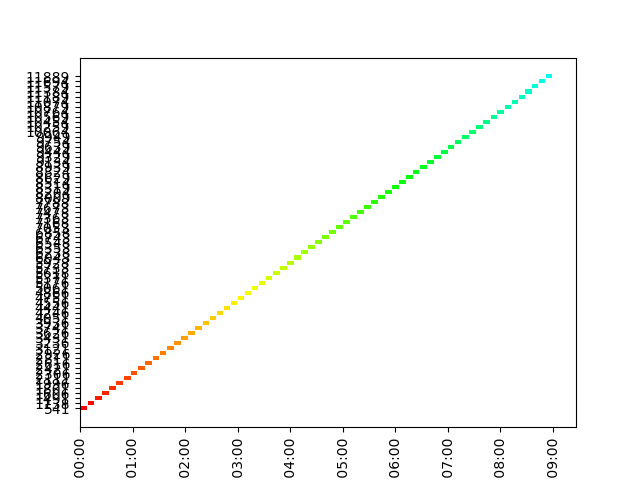

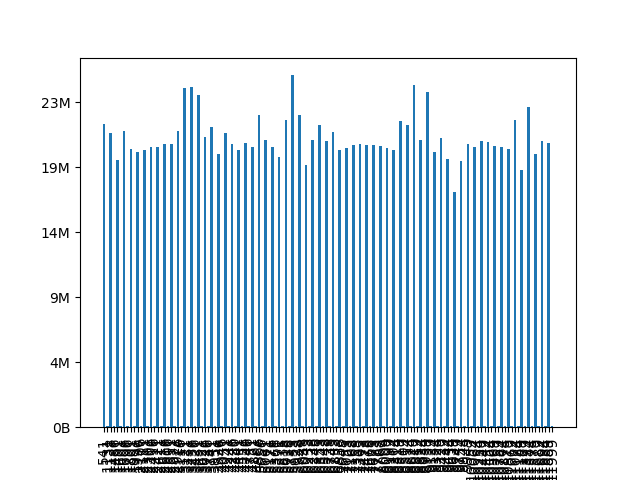

[1.00000000e+00 9.80363837e+00 9.61113252e+01 9.42240675e+02
 9.23738684e+03 9.05600000e+04]


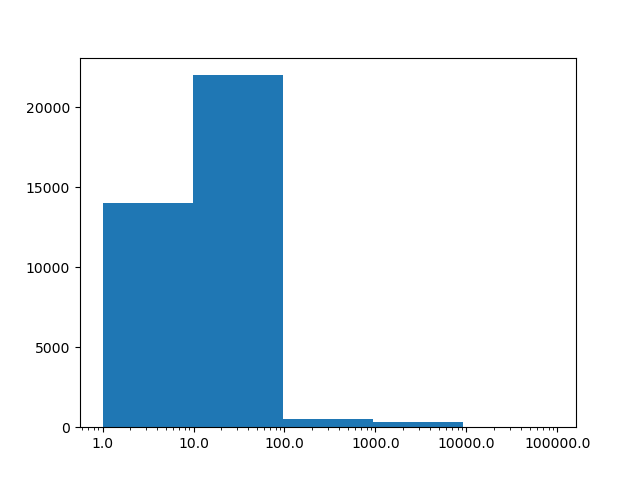

In [88]:
input_files, output_files = filter_input_files()
hashes = load_hashes()
write_input_output_files_with_hash(hashes, input_files, output_files, "files_with_perf.txt")

In [22]:
filtered_in, filtered_out = filter_input_files()
hashes = load_hashes()
write_input_output_files_with_hash(hashes, filtered_in, filtered_out, "new_filtered.txt")

Filtering Inputs/Outputs of 507 Tasks based on strace reports
0%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
1%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
3%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
5%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
7%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
9%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
11%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
13%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
15%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
17%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
19%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
21%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
23%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
25%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
27%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
29%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
31%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
33%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
35%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
37%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
39%
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
41%
8 8
8 8
8 8
8 8


In [8]:
input_files['preprocessing:mergeBOA']['(X0106_Y0102)'].keys()

dict_keys(['/workdir/work/c4/468369424b4e6e7a078b60bee0169d/level2_ard/X0106_Y0102/20160610_LEVEL2_LND07_BOA.tif', '/workdir/work/e7/a3bb236e1e398532a91e3d3fef62b1/level2_ard/X0106_Y0102/20160930_LEVEL2_LND07_BOA.tif', '/workdir/work/54/ddb8785ab24412fb9cc178fa6eb8b4/level2_ard/X0106_Y0102/20161016_LEVEL2_LND07_BOA.tif', '/workdir/work/a8/d04c733b6567a99dbe5f5de01cabca/level2_ard/X0106_Y0102/20161016_LEVEL2_LND07_BOA.tif', '/workdir/work/88/526bc05d80814ef362b37497f54416/level2_ard/X0106_Y0102/20161203_LEVEL2_LND07_BOA.tif', '/workdir/work/08/b52279bce627d5dbc42fdedafdd1b8/level2_ard/X0106_Y0102/20161203_LEVEL2_LND07_BOA.tif', '/workdir/work/0e/41ace8b7a582fdb9209fcbd8b0b8a1/level2_ard/X0106_Y0102/20160610_LEVEL2_LND07_BOA.tif', '/workdir/work/27/941ca4929cb99694f82e5c526f133c/level2_ard/X0106_Y0102/20160626_LEVEL2_LND07_BOA.tif', '/workdir/work/a3/933535879e690ecbc0c86752c9fb25/level2_ard/X0106_Y0102/20160626_LEVEL2_LND07_BOA.tif', '/workdir/work/a8/79ee3bdc5155cec658344c4215849b/leve